In [12]:
import numpy as np
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

  
import h5py
import os.path
dataset=None
timerange=None
freqrange=None
ids=None
base_dir = '/project/lofarsw/Data/Dynspec/'
fpath = os.path.join(base_dir, 'dset.h5')
lpath = os.path.join(base_dir, 'labels.csv')


ts_to_klass = None
with open(lpath, 'r') as f_in:
  ts_to_klass = {x[0]: int(x[1]) for x in map(lambda x: x.split(','), filter(lambda x: x, f_in.read().split('\n')[1:]))}

with h5py.File(fpath, 'r') as fin:
  in_dataset=fin['/data'][:]
  in_timerange=fin['/time_range'][:]
  in_freqrange=fin['/freq_range'][:]
  in_ids=fin['timestamps'][:]
  in_label_names = {1: 'Type I storm', 2: 'Type II', 3: 'Type III', 4: 'Type IV',  5: 'Atypical', 6: 'Nothing'}
  
g = np.where(~np.isnan(in_dataset.sum(axis=(1,2))))

in_labels_to_klass = {1: 2, 2:2, 3:1, 4:2, 5:2, 6:3, -1: -1}
#in_label_names = {1: 'TypeIII', 2: 'NotTypeIII', 3: 'Nothing'}

dataset = in_dataset[g]
timerange= in_timerange[g]
freqrange= in_freqrange[g]
ids = in_ids[g]
#avg = dataset[:, :, 404]


klasses = np.array([ts_to_klass.get(ts.decode(), -1) for ts in ids], dtype=int)
#for k in range(klasses.shape[0]):
#  klasses[k] = in_labels_to_klass[klasses[k]]
n_per_klass = np.array(list([np.where(klasses == i + 1)[0].shape[0] for i in range(len(in_label_names))]))

dataset = dataset[:, :, 300:]
shape = dataset.shape

dataset = dataset.reshape((*shape, 1))

In [13]:
with_label = np.where(klasses != -1)[0]
class_names = list(in_label_names.keys())
num_classes = len(class_names)
import numpy.random as r
r.shuffle(with_label)
shuffled_dset = dataset[with_label, :, :, :]
shuffled_ids = dataset[with_label]
shuffled_klasses = klasses[with_label] - 1
img_height, img_width, _ = dataset[0].shape
batch_size = 16
training_size = 2000
test_size = 200
validation_size = len(with_label) - training_size - test_size
n_per_klass = np.array(list([np.where(klasses == i + 1)[0].shape[0] for i in range(num_classes)]))
weights = len(klasses) / n_per_klass / num_classes
print(weights, num_classes, n_per_klass, shuffled_dset.shape)
class_weights = {i: 1 for i in range(num_classes)}
tfdataset = tf.data.Dataset.from_tensor_slices((shuffled_dset, shuffled_klasses)).shuffle(len(with_label), seed=42)


training_dset = tfdataset.take(training_size).batch(batch_size)
validation_dset = tfdataset.skip(training_size).take(validation_size).batch(batch_size)
test_dset = tfdataset.skip(training_size).skip(validation_size).take(test_size).batch(batch_size)



[  2.34257603  93.53571429   0.84812176 654.75        10.9125
   2.70557851] 6 [ 559   14 1544    2  120  484] (2723, 500, 500, 1)
125 33 13


500 500
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_translation_1 (Rando  (None, 500, 500, 1)      0         
 mTranslation)                                                   
                                                                 
 conv2d_3 (Conv2D)           (None, 500, 500, 16)      160       
                                                                 
 spatial_dropout2d_1 (Spatia  (None, 500, 500, 16)     0         
 lDropout2D)                                                     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 250, 250, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 250, 250, 32)      4640      
                                              

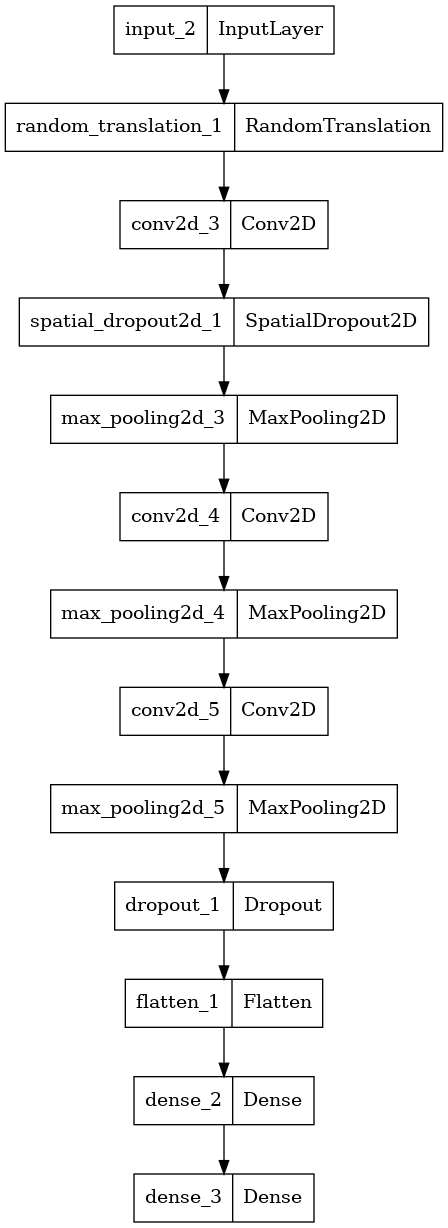

In [4]:


import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
print(img_height, img_width)
model = Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 1)),
  layers.RandomTranslation(height_factor=(-.1, .1), width_factor=0),
  #layers.RandomCrop(height=40, width=150),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.SpatialDropout2D(.2),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
keras.utils.plot_model(model, 'convsupervised.png')

In [4]:
epochs=100
history = model.fit(
  training_dset,
  validation_data=validation_dset,
  epochs=epochs
)

Epoch 1/100


2023-04-13 17:59:34.582854: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/spatial_dropout2d/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-04-13 17:59:35.011344: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-04-13 17:59:35.285319: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f04bc003e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-13 17:59:35.285604: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-04-13 17:59:35.292096: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-13 17:59:35.457476: I tensorflow/compiler/jit/xla_compilation_cache

125/125 [==============================] - 14s 80ms/step - loss: 1.4506 - accuracy: 0.5660 - val_loss: 0.9249 - val_accuracy: 0.6348
Epoch 2/100
125/125 [==============================] - 8s 66ms/step - loss: 0.9135 - accuracy: 0.6355 - val_loss: 0.8889 - val_accuracy: 0.6922
Epoch 3/100
125/125 [==============================] - 8s 66ms/step - loss: 0.8779 - accuracy: 0.6515 - val_loss: 0.8538 - val_accuracy: 0.6501
Epoch 4/100
125/125 [==============================] - 8s 66ms/step - loss: 0.8219 - accuracy: 0.6725 - val_loss: 0.8813 - val_accuracy: 0.6482
Epoch 5/100
125/125 [==============================] - 8s 67ms/step - loss: 0.8178 - accuracy: 0.6785 - val_loss: 0.7375 - val_accuracy: 0.6922
Epoch 6/100
125/125 [==============================] - 8s 65ms/step - loss: 0.7868 - accuracy: 0.7000 - val_loss: 0.7241 - val_accuracy: 0.7323
Epoch 7/100
125/125 [==============================] - 8s 65ms/step - loss: 0.7674 - accuracy: 0.6905 - val_loss: 0.7162 - val_accuracy: 0.7476
Epo

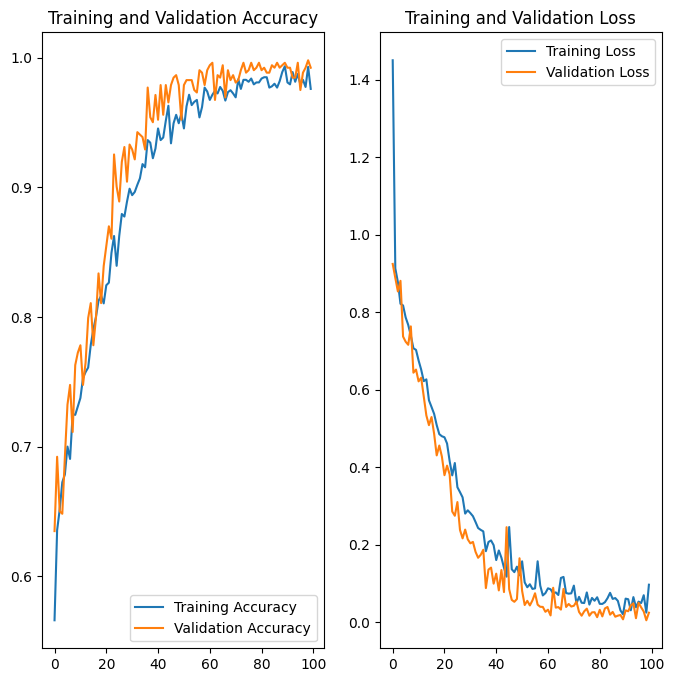

In [5]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [23]:
import seaborn as sns
def predict_labels(dset, size):
  predictions = []
  labels = []
  
  for image, label in dset.batch(256).take(size):
    
    prediction = model.predict(image)
    predictions += list(prediction)
    labels += list(label)
    
  
  results = [tf.nn.softmax(row) for row in predictions]
  results = [np.argmax(row) for row in results]
  accuracy = [np.max(row) for row in results]
  
  return results, labels, accuracy

def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()
  
choose_dset = tfdataset

print('Dataset size is', len(choose_dset))


true_classes = []

predicted_classes, true_classes, accuracy = predict_labels(choose_dset, len(tfdataset))
print(len(predicted_classes), len(true_classes))
#print(np.array(labels[0]), predicted_classes[0])
errors = np.where(np.array(predicted_classes) != np.array(true_classes))

conf_matrix = tf.math.confusion_matrix(true_classes, predicted_classes, num_classes = num_classes)
show_confusion_matrix(conf_matrix, [in_label_names[k+1] for k in range(num_classes)])

Dataset size is 2723
6/6 [==============================] - 0s 17ms/step
2723 2723


In [6]:
from datetime import datetime as datetime
model.load_weights(f'CONVOLUTION_SUPERVISED_2023-04-13T18:13:09.261310.h5')
#model.save(f'CONVOLUTION_SUPERVISED_{datetime.now().isoformat()}')

246/246 [==============================] - 4s 16ms/step
(7857, 6)
86/86 [==============================] - 1s 16ms/step
(2723, 6)


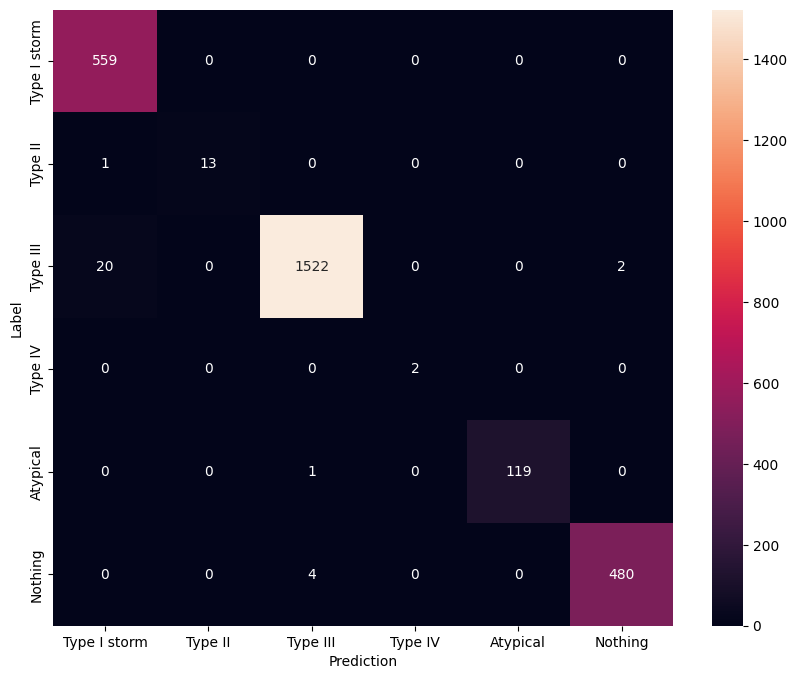

In [12]:
def predict_labels_np(dataset):
  predictions = model.predict(dataset)
  print(predictions.shape)
  probabilities = tf.nn.softmax(predictions, axis=1)
  label = np.argmax(probabilities, axis=1)
  probability = np.max(probabilities, axis=1)
  return label, probability

prediction, probability = predict_labels_np(dataset)
prediction_verifiable, _ = predict_labels_np(dataset[with_label, : , :, :])

conf_matrix = tf.math.confusion_matrix(klasses[with_label] - 1, prediction_verifiable, num_classes = num_classes)
show_confusion_matrix(conf_matrix, [in_label_names[k+1] for k in range(num_classes)])

In [9]:
print(klasses[with_label[0]], ids[with_label[0]])
print(ts_to_klass.get(ids[with_label[0]].decode()))

3 b'859344_2022-05-05_13:15:00.000000'
3


In [13]:
ids = in_ids[g]
whole_dataset = in_dataset[g]

In [14]:
base_dir = f'/project/lofarsw/Public/bf_dynspec/new_classes/{datetime.now().isoformat()}'
import os
from tqdm import tqdm
for ids_i, image, label, prob, frange in tqdm(zip(ids, whole_dataset, prediction, probability, freqrange), total=ids.shape[0]):
  true_klass = ts_to_klass.get(ids_i.decode(), None)
  true_label = in_label_names[true_klass] if true_klass is not None else ''
  label_name = in_label_names[label + 1]
  klass_path = os.path.join(base_dir, label_name)
  os.makedirs(klass_path, exist_ok=True)
  file_name = f'{ids_i.decode()}_{true_label.replace(" ", "-").lower()}.png'
  file_path = os.path.join(klass_path, file_name)
  
  f = plt.figure(figsize=(10 , 5))
  plt.title(f'{ids_i.decode().replace("_", " ")} - Predicted: {label_name} - True: {true_label}')
  plt.imshow(image.T, aspect='auto', origin='lower', extent=[0, 15, *frange])
  plt.xlabel('t [min]')
  plt.ylabel('Frequency [MHz]')
  plt.minorticks_on()
  plt.colorbar(label='Normalized intensity')
  plt.savefig(file_path)
  plt.close(f)

100%|██████████| 7857/7857 [52:39<00:00,  2.66it/s]  


In [5]:
import tensorflow as tf

model = tf.keras.models.load_model('CONVOLUTION_SUPERVISED_2023-04-13T18:13:09.261310')
model.save('CONVOLUTION_SUPERVISED_2023-04-13T18:13:09.261310.h5')